In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/opt/homebrew/anaconda3/envs/torchenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch:  1.14 ; cuda:  1.14.0.dev20221014
detectron2: 0.6


In [2]:
from detectron2.utils.logger import setup_logger
setup_logger()

import os
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import glob
import cv2
from matplotlib import pyplot as plt
import torch
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import inference_on_dataset

In [3]:
project_path = "../"
register_coco_instances("train", {}, os.path.join(project_path, "data/annotations/train_filtered.json"), os.path.join(project_path, "data/train"))
register_coco_instances("val", {}, os.path.join(project_path, "data/annotations/val_filtered.json"), os.path.join(project_path, "data/val"))
register_coco_instances("test", {}, os.path.join(project_path, "data/annotations/test_filtered.json"), os.path.join(project_path, "data/test"))

In [4]:
cfg = get_cfg()
# Use pretrained model parameters of mask_rcnn_R_50_FPN_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("test",)
cfg.DATALOADER.NUM_WORKERS = 2 # Dataloader workers
cfg.MODEL.WEIGHTS = "./output/20221119/model_0004999.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.MASK_ON = True # Mask
cfg.OUTPUT_DIR = os.path.join(project_path, "notebooks/output/")
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

[11/22 13:36:03 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

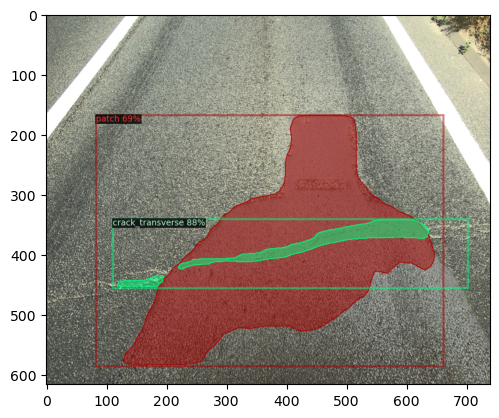

../data/shadows/A11EBWBRedLodgetoBartonMills_sideview_000010_000123_Lane1resized30.jpg


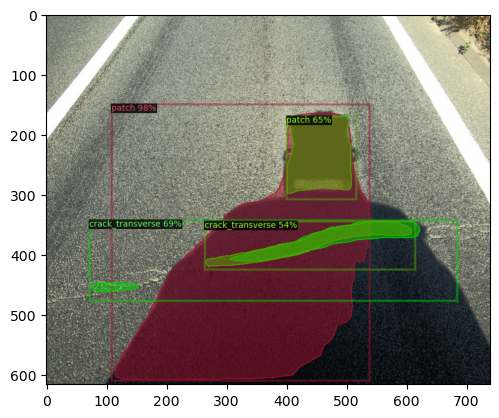

../data/shadows/A11EBWBRedLodgetoBartonMills_sideview_000010_000123_Lane1.jpg


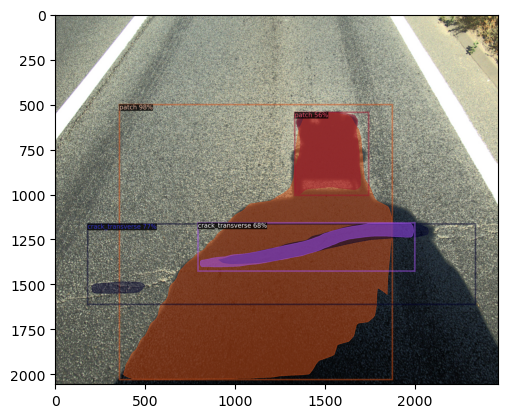

In [18]:
predictor = DefaultPredictor(cfg)

train_ds = DatasetCatalog.get("train")
metadata = MetadataCatalog.get("train")

shadows_files = glob.glob(os.path.join(project_path, "data/shadows/[!pred]*"))
pred_images_output_dir = os.path.join(project_path, "data/shadows/pred")

for d in shadows_files:  
    print(d)  
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
        metadata=metadata,
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(cv2.cvtColor(out_pred.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    cv2.imwrite(os.path.join(pred_images_output_dir, "{}_pred.jpg".format(d.split('/', -1)[-1][:-4])), cv2.cvtColor(out_pred.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))